In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3" # put -1 to not use any

In [2]:

import numpy as np 
import os
import pandas as pd
from torch.utils.data import DataLoader
from nets.classification import ResNetLSTM_p2, ResNetLSTM
from loaders.hyst_dataset import HystDataset, TestTransforms

import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colormaps
import torch.multiprocessing

/tools/anaconda3/envs/flyby/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### hysterectomy

In [3]:
# video_fold = '/CMF/data/lumargot/hysterectomy/csv_files/updates/per_vid/'
# names = ['DPM_12.14.22e.csv', 'DPM_1.24.23.csv', 'DPM_1.30.23.csv', 'JC_3.21.2023b.csv', 'Res_2.27.23b.csv']
# ckpt = '/CMF/data/lumargot/ResNetLSTM/hyst/output/epoch=17-val_loss=4.40.ckpt'
# mount_point='/CMF/data/lumargot/hysterectomy/Clips/'

### Gastric ByPass

In [4]:
df_test = pd.read_csv('/CMF/data/lumargot/ResNetLSTM/GBP/output/no_early_stopping/GBP_test_prediction.csv')
# video_fold =
names = np.unique(df_test['id'])
ckpt = '/CMF/data/lumargot/ResNetLSTM/GBP/model/full_network/v3/epoch=10-val_loss=3.86.ckpt'
mount_point = '/CMF/data/lumargot/GBP_9.30.23/subsample/'

In [5]:
model = ResNetLSTM_p2.load_from_checkpoint(ckpt, strict=True)
model.eval()
model.cuda()
model.memory_model.eval()
model.memory_model.cuda()

ResNetLSTM(
  (accuracy): MulticlassAccuracy()
  (loss): CrossEntropyLoss()
  (model_dict): ModuleDict(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, t

In [6]:
l_start = []
l_end = []

df_id = df_test.loc[df_test['id']==names[0]]
for idx, row in df_id.iterrows():
    vid_path = row['vid_path']
    name, ext = os.path.splitext(vid_path)

    min_f = int(name.split('_')[-2])
    max_f = int(name.split('_')[-1])

    l_start.append(min_f)
    l_end.append(max_f)

df_id['start'] = l_start
df_id['end'] = l_end

df_id = df_id.sort_values(by=['start'])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
def read_and_select_mp4_frames_cv2(vid_path=vid_path, frame_idx=0, num_frames=30,
                                   video_length=50, mount_point=mount_point):

    cap = cv2.VideoCapture(os.path.join(mount_point, vid_path))
    transform = TestTransforms(height=256, num_frames=num_frames)
    # total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) - frame_idx


    step = 30
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    if total_frames < num_frames:
        return torch.zeros(self.num_frames, self.img_size, self.img_size, 3, dtype=torch.float32)


    start_idx = max(0,total_frames - num_frames*step)
    if start_idx !=0:
        start_idx = np.random.randint(0,start_idx, (1,))


    end_idx = start_idx + num_frames*step
    idx = torch.arange(int(start_idx), int(end_idx), step)


    if end_idx > total_frames:
        end_idx = min(start_idx + num_frames, total_frames)
        idx = torch.arange(int(start_idx), int(end_idx))

    frames = []
    for frame_number in idx:

        cap.set(cv2.CAP_PROP_POS_FRAMES, int(frame_number))
        success, frame = cap.read()
        if success:
            frames.append(frame)
        else:
            frames.append(np.zeros_like(frames[-1]))    

    video = np.stack(frames, axis=0)
    video = transform(video)

    cap.release()
    cv2.destroyAllWindows()

    return video


In [8]:
vid = read_and_select_mp4_frames_cv2(vid_path)

In [9]:
vid.shape

torch.Size([30, 3, 256, 256])

### Display

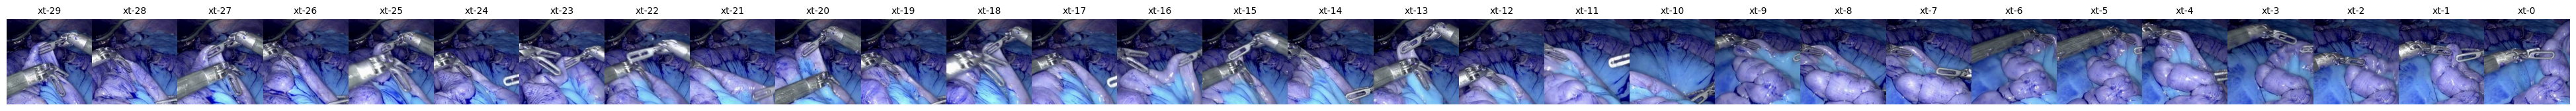

In [10]:
def plot_frames(vid, num_frames):

    # vid: shape of 30, 3, 256, 256

    # image_size = (120, 120)  # Replace with your image size
    # dpi = 100  # 100 dots per inch is a common screen resolution
    # fig_width = 10 * image_size[0] / dpi  # Calculate the width based on the number of images
    # fig_height = image_size[1] / dpi  # Calculate the height based on a single image height

    # Create the figure with the computed size
    fig, axes = plt.subplots(1, num_frames, figsize=(50, 20))


    # Display each frame in its subplot
    for i, ax in enumerate(axes):
        # Assume the video has 3 channels (RGB)
        f = vid[i,:,:,:]
        frame = np.transpose(f, (1, 2, 0))  # Change to H, W, channel for plotting
        ax.imshow(frame)
        
        ax.axis('off')  # Hide the axes
        ax.set_title(f'xt-{num_frames-1 -i}', fontsize=10)  # Customize as per your needs

    plt.subplots_adjust(wspace=0, hspace=0)
    # If you are using tight_layout, you can also specify the spacing with the 'pad' parameter
    # Add overall annotations
    plt.suptitle('', fontsize=14)
# plt.figtext(0.9, 0.5, 'Baseline: 0.71\n▼', ha='center', fontsize=14)


plot_frames(vid, 30)
# Adjust layout
# plt.tight_layout(pad=0)

In [12]:
def plot_features(feature, n_frames):

    # print(feature.shape) # shape of 30, 1 512

    # image_size = (60, 120)  # Replace with your image size
    # dpi = 100  # 100 dots per inch is a common screen resolution
    # fig_width = 10 * image_size[0] / dpi  # Calculate the width based on the number of images
    # fig_height = image_size[1] / dpi  # Calculate the height based on a single image height

    # Create the figure with the computed size
    fig, axes = plt.subplots(1, n_frames, figsize=(16, 4))

    # Display each frame in its subplot
    for i, ax in enumerate(axes):
        # Assume the video has 3 channels (RGB)
        f = feature[0,i,:].cpu().numpy()
        
        n_copies = 60
        f = np.tile(f, n_copies)
        f = f.reshape((n_copies, 512))

        frame = f.transpose(1, 0)  # Change to H, W, channel for plotting
        ax.imshow(frame, cmap='gray', vmin=f.min(), vmax=f.max())
        ax.axis('off')  # Hide the axes
        ax.set_title(f'xt-{n_frames-1 -i}', fontsize=10)  # Customize as per your needs

    plt.subplots_adjust(wspace=0, hspace=0)
    # If you are using tight_layout, you can also specify the spacing with the 'pad' parameter
    # Add overall annotations
    plt.suptitle('', fontsize=14)
# plt.figtext(0.9, 0.5, 'Baseline: 0.71\n▼', ha='center', fontsize=14)

# Adjust layout
plt.tight_layout(pad=0)
    
# plot_features(long_features, 30)

<Figure size 640x480 with 0 Axes>

### compute predictions

In [11]:
frame_length = 30
predictions = []
true_labels = []
labels_name = []
n_problem = 0
batch_size = 1
idx_reading = 0

with torch.no_grad():
    for idx, row in df_id.iterrows():
        vid_path = row['vid_path']
        start_frame = 0
        length_vid = row['end'] - row['start'] 
        end_frame = row['end'] - row['start'] - frame_length ## cause videos always start from 0 :D
        y_true = row['tag']
        y_label = row['class']
        
        print(end_frame, start_frame)
        if end_frame - start_frame >= 0:
            print(f"Reading video {idx_reading} / {len(df_id)}")
            
            for frame_idx in range(start_frame, end_frame+1):

                X = read_and_select_mp4_frames_cv2(vid_path=vid_path, frame_idx=frame_idx, num_frames=frame_length,
                                                    video_length=length_vid, mount_point=mount_point)
                X = X.view(batch_size, frame_length, 3, 256, 256)
                X = X.cuda().contiguous()


                long_features= model.memory_model(X) # (BS* num_frames, 512)
                long_features = long_features.view(-1, frame_length, 512)

                ## take only 10 frames in x
                X = X[:,-10:,:,:,:]

                batch_size, num_frames, channels, height, width = X.size()

                ## creating features
                pred = model.forward(X, long_features)
                pred = torch.argmax(pred, dim=1).cpu().numpy()
                
                predictions.append(pred)
                true_labels.append(y_true)
                labels_name.append(y_label)
        else:
            print(f"file {idx_reading} / {len(df_id)} - skipping video, not enough frames")
        idx_reading+=1

127 0
Reading video 0 / 13


75 0
Reading video 1 / 13
672 0
Reading video 2 / 13
116 0
Reading video 3 / 13
8 0
Reading video 4 / 13
45 0
Reading video 5 / 13
593 0
Reading video 6 / 13
93 0
Reading video 7 / 13
49 0
Reading video 8 / 13
23 0
Reading video 9 / 13
457 0
Reading video 10 / 13
104 0
Reading video 11 / 13
-5 0
file 12 / 13 - skipping video, not enough frames


In [12]:
df = pd.DataFrame({'index': range(len(true_labels)),
                   'true_label': true_labels,
                   'predicted_label': predictions,
                   'class_names':labels_name,
                   })

In [13]:
outfile = 'predicted_values_'+str(names[0])+'.csv'
df.to_csv(outfile)

In [ ]:
labels = ['Class 1 ', 'Class 2', 'Class 3']

In [22]:
df_test = pd.read_csv('/home/lumargot/hysterectomy-coach/src/py/predicted_values_26.csv')

classes_tag = np.unique(df_test['true_label'])
classes_label = np.unique(df_test['class_names'])

dic = dict(zip(classes_tag, classes_label))


print(len(classes_tag))

12


In [39]:
df.sort_values(by=['true_label'])

,index,true_label,predicted_label,class_names
1186,1186,0,[0],g-j a
1301,1301,0,[0],g-j a
1300,1300,0,[2],g-j a
1299,1299,0,[0],g-j a
1298,1298,0,[2],g-j a
...,...,...,...,...
1808,1808,13,[13],rny
1809,1809,13,[13],rny
1810,1810,13,[13],rny
1798,1798,13,[13],rny


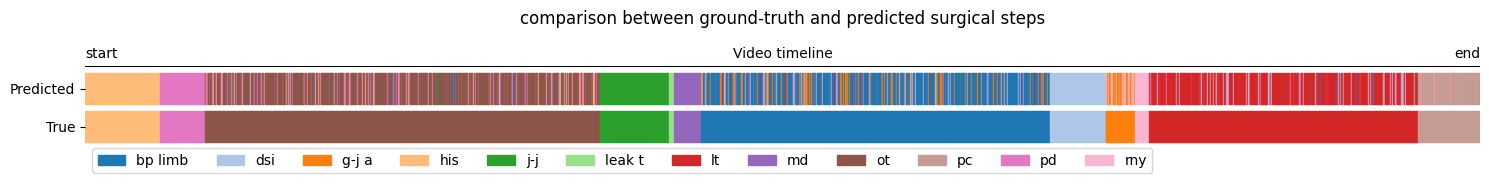

In [37]:
cmap = colormaps['tab20']
n_labels = len(classes_tag)

# Create a color mapping for the labels
label_colors = {0:cmap.colors[0], 1:cmap.colors[1], 2:cmap.colors[2], 3:cmap.colors[3], 4:cmap.colors[4], 5:cmap.colors[5], 6:cmap.colors[6],
                7:cmap.colors[7], 8:cmap.colors[8], 9:cmap.colors[9], 10:cmap.colors[10], 11:cmap.colors[11], 12:cmap.colors[12], 13:cmap.colors[13] }


def plot_timeline(ax, labels, y_pos, height, color_mapping):
    # Plot each segment in the timeline
    for i, label in enumerate(labels):
        color = color_mapping.get(label, '#000000')  # Default to black if label not found
        ax.add_patch(patches.Rectangle((i, y_pos), 1, height, color=color))

# Prepare the figure
fig, ax = plt.subplots(figsize=(15, 2))  # Adjust the size as needed
ax.set_xlim(0, len(df_test['true_label']))  # Set the x-axis limits to the number of labels
ax.set_ylim(-0.5, 1)  # Set the y-axis limits to accommodate the true and predicted labels

# Plot the true labels
plot_timeline(ax, df_test['true_label'], y_pos=0, height=0.4, color_mapping=label_colors)
# Plot the predicted labels
plot_timeline(ax, df_test['predicted_label'], y_pos=0.5, height=0.4, color_mapping=label_colors)


ax.plot([0, len(df_test['true_label'])], [1, 1], color='black')  # Line for the video timeline
ax.text(len(df_test['true_label']) / 2, 1.1, 'Video timeline', ha='center')  # Title for the video timeline
ax.text(0, 1.1, 'start', ha='left')  # Title for the video timeline
ax.text(len(df_test['true_label']), 1.1, 'end', ha='right')  # Title for the video timeline


# Customize the y-axis
ax.set_yticks([0.2, 0.7])
ax.set_yticklabels(['True', 'Predicted'])

# Turn off the x-axis visibility as we are not showing real time
ax.get_xaxis().set_visible(False)


patch_list = []
for idx in classes_tag.tolist():
    patch = patches.Patch(color=label_colors[idx], label=idx)
    patch_list.append(patch)

# ax.legend(handles=patch_list, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.legend(handles=patch_list,  loc='best',ncol=n_labels, labels=dic.values())

# Remove spines --> box lines
for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_title("comparison between ground-truth and predicted surgical steps", pad=30)
fig.savefig("video_timeline.png", bbox_inches='tight')
# Show the plot
plt.tight_layout()
plt.show()
